### Version of use package: 
1. pandas version: 1.0.1
2. mne version: 0.20.6 
3. numpy version:  1.18.1
4. matplotlib version:  3.1.3

### Data
1. Please load csv file: shiyang/minjiun/pinhan/yalin/chihheng.csv into this ipynb.
2. event_marker.csv: used for identifying category of image. 

## Analysis procedure
0. Downsampling? [not yet]  
1. Load events in mne [done]   
event=1(stimulus, picture showing(every animal)),2(response, onclick)
define target: cat didnot click & noncat click, nontarget: cat click & noncat didnot click
ERP & ERN  
https://mne.tools/stable/auto_tutorials/preprocessing/plot_20_rejecting_bad_data.html#sphx-glr-auto-tutorials-preprocessing-plot-20-rejecting-bad-data-py  
Total number of Image: 359, *the last 1 in subject csv means the end of session!*  
*Change event type: 0: nan, 1: cat image, 2: noncat image, 3: click*  
Unit of EEG data in csv: $\mu V$, Unit of EEG data in mne: $V$ -> all EEG channel need to be divided 10^6.  
    + Need to extract target and nontarget
2. Extract epochs: [-0.2,0.5] with bsaeline removal [done]  
3. Artifact Removal: 
    + By amplitude [done]
    + By ICA: https://mne.tools/stable/auto_tutorials/preprocessing/plot_40_artifact_correction_ica.html [not yet]  
    + tSSS [not yet]  
    + SSP [not yet]  
4. Plot ICA components [montage issue] : download montage file from EEGLab or Cygnus (built-in montage files in mne are improper.)  [not yet]   
Use biosemi64 and delete irrelevent channels.
5. Plor PSD  [not yet] 
6. Plot ERP/ERN: https://mne.tools/0.16/auto_tutorials/plot_eeg_erp.html  [not yet]   

In [11]:
# (Optional) Upgrade mne
!pip install -U mne

     |████████████████████████████████| 6.6 MB 1.2 MB/s eta 0:00:01
  Attempting uninstall: mne
    Found existing installation: mne 0.19.2
    Uninstalling mne-0.19.2:
      Successfully uninstalled mne-0.19.2


What is Serial Number in csv?

In [1]:
import pandas as pd
import mne 
from mne.preprocessing import ICA
import numpy as np
import matplotlib.pyplot as plt
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
print('pandas version: ',pd.__version__)
print('mne version: ',mne.__version__)
print('numpy version: ',np.__version__)
import matplotlib
print('matplotlib version: ',matplotlib.__version__)

pandas version:  1.0.1
mne version:  0.20.6
numpy version:  1.18.1
matplotlib version:  3.1.3


In [3]:
'''
dataloader:  A function used for loading csv data.
===================================================================================================
Input variable(s):
subject_file: Directory of EEG data(deleted Meta Info) of subject in csv. (in default directory)
===================================================================================================
Output:
data: subject data without EEG data after the end of session.
'''
def dataloader(subject_file):
    # Step 1: Load EEG data (32 sensor channels and 1 STIM channel(Software Marker)) 
    column_use=[i for i in range(2,34)]
    column_use.append(37)
    data=pd.read_csv(subject_file,usecols=column_use)
    # Step 2: Delete EEG data after the end of sesssion (The last 1 in Software Marker column indicates the end of session)
    end=data.index[data['Software Marker']==1][-1]
    data=data.iloc[:end,:]
    return data

In [4]:
data=dataloader('minjiun.csv')
event=pd.read_csv('event_marker.csv')

In [5]:
data.index[data['Software Marker'] == 1]

Int64Index([  3104,   3606,   4110,   4613,   5116,   5620,   6120,   6623,
              7126,   7630,
            ...
            413142, 414145, 415149, 416152, 417155, 418158, 419162, 420165,
            421168, 422172],
           dtype='int64', length=359)

In [6]:
'''
ChangeEventID: A function used for modifying event ID of cat images, noncat images, and clicks in subject data. 
=================================================================================================================
Input variable(s):
event: event_marker csv file, which records image category.
data: subject data that contains event ID (Software Marker) ( nan, 1: (cat or noncat) image show, 2: click)
=================================================================================================================
Output:
data: subject data with redefined event ID (Software Marker) ( 0:nan, 1:cat image show, 2: noncat image show, 3: click )
=================================================================================================================
Notice: 
1. If image number of data is not equal to image number of event, ChangeEventID just returns original data.
2. If index of cat image(in list of all image) in data is not equal to index of cat image(in list of all image) in event marker,
   ChangeEventID just returns original data.
'''
def ChangeEventID(event,data):
    
    # Step 0: check if image number in data is same as image number in event
    # l_data: index list of all images in data (len(l_data)=359, range(cat_index)=[0,1.,...,len(data)])
    l_data=data.index[data['Software Marker'] == 1]#.tolist()
    # l_event: index list of all images in event marker (len(l_event)=359, range(cat_index)=[0,1.,...,len(event)])
    l_event=event.index[event['Type']=='Picture'].tolist()
    if len(l_data)!=len(l_event):
        print('Image number of data is not equal to image number of event!')
        return data
    else: print('Changing event ID of data ... ...')
    
    # Step 1: Convert nan into 0 in Software Marker column of data
    data['Software Marker'].fillna(0, inplace=True)
    #         Convert 2 into 3 in Software Marker column of data
    data['Software Marker'].replace({2:3},inplace=True)
    #         Convert 1 into 2 in Software Marker column of data
    data['Software Marker'].replace({1:2},inplace=True)
    
    # Step 2: Find index of cat image in data, and convert 2 into 1 for cells w.r.t. these indices
    filter=(event['Type']=='Picture')&(event['Event']=='0')
    cat_event_marker=event.index[filter].tolist()
    # cat_index: index list of cat image in all images (len(cat_index)=35, range(cat_index)=[0,1.,...,358])
    cat_index=[l_event.index(cat_img) for cat_img in cat_event_marker if cat_img in l_event]
    for i in cat_index:#l_data[i]: real index in data
        data.at[l_data[i],'Software Marker']=1
    
    # Step 3: check if the conversion of event ID for cat image is correct or not
    data_index=data[(data['Software Marker']==1)|(data['Software Marker']==2)].reset_index()
    # data_index=data_index.reset_index()
    data_index=data_index.index[data_index['Software Marker']==1].tolist()
    if cat_index!=data_index:
        print('Fail to convert event ID!')
        return data
    else: print('Finish index checking!')
    return data

In [7]:
new_data=ChangeEventID(event,data)

Changing event ID of data ... ...
Finish index checking!


1. Delete bad Epoch: https://mne.tools/stable/generated/mne.Epochs.html
2. Epoch basic: https://mne.tools/0.16/auto_tutorials/plot_epoching_and_averaging.html#tut-epoching-and-averaging

In [8]:
new_data.columns

Index(['Fp1', 'Fp2', 'AF3', 'AF4', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT7', 'FC3',
       'FCz', 'FC4', 'FT8', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP7', 'CP3', 'CPz',
       'CP4', 'TP8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2',
       'Software Marker'],
      dtype='object')

In [9]:
'''
mneLoadIn: A function used for loading cleaned EEG data into mne. 
=================================================================================================================
Input variable(s):
new_data: subject data with redefined event ID (Software Marker) ( 0:nan, 1:cat image show, 2: noncat image show, 3: click )
=================================================================================================================
Output:
raw: mne.io.RawArray (EEG data with Info).
events: 3D np.array (TimestampIndex, 0, event ID)
epochs: mne.Epochs with baseline removal and artifact removal (by amplitude)
=================================================================================================================
Notice: 
1. Unsolved montage issue results in failure of plotting ICA components in topography.
2. Preprocessing (Bandpass filtering, Find Event, and Extract Epoch) procedure is fixed in this version.
'''
def mneLoadIn(new_data):
    
    # Step 1: Change unit of data (mu V-> V) except stim channel
    for i in range(32):
        new_data.T.iloc[i,:]=new_data.T.iloc[i,:]/10**6
        
    # Step 2: Create RawArray in mne
    # ch_names: Name list of channels
    ch_names = list(new_data.T.index)  
    # sfreq: Sampling rate of the EEG data in Hz
    sfreq = 500  
    ch_types=['eeg' for i in range(32)]
    ch_types.append('stim')
    montage = mne.channels.make_standard_montage('biosemi32')
    # Create the info structure needed by MNE
    info = mne.create_info(ch_names, sfreq, ch_types)# , montage=montage
    # info.set_montage('GSN-HydroCel-32')#'biosemi32'
    # Create the Raw object
    raw = mne.io.RawArray(new_data.T.values, info,copy='info')
    print('Plot raw EEG data!')
    raw.plot()
    
    # Step 3: preprocessing (without downsampling)
    #         Bandpass filtering [1,40] Hz
    raw=raw.filter(1, 40, fir_design='firwin', picks=np.arange(32))
    print('Plot EEG data after bandpass [1,40] Hz!')
    raw.plot()
    #         Find events in EEG data
    events = mne.find_events(raw)
    print('Plot EEG data with events!')
    raw.plot(events=events)
    print('Start to extract epochs with artifact removal.')
    #        Extract Epoch with baseline removal and artifact removal (by amplitude).
    reject_criteria = dict(eeg=150e-6) # max amplitude:150 µV
    flat_criteria = dict(eeg=1e-6) # min amplitude:1 µV
    # baseline: start from -0.2(s) and end to 0(s) before start of stimulus 
    baseline=(-0.2,0)
    epochs = mne.Epochs(raw, events, event_id=[1,2], tmin=-0.2, tmax=0.5, baseline=baseline,
                        reject=reject_criteria,picks=np.arange(32))#, flat=flat_criteria
    print('Plot epochs!')
    epochs.plot(block=True)
    return raw, events, epochs

Creating RawArray with float64 data, n_channels=33, n_times=423175
    Range : 0 ... 423174 =      0.000 ...   846.348 secs
Ready.
Plot raw EEG data!


<IPython.core.display.Javascript object>


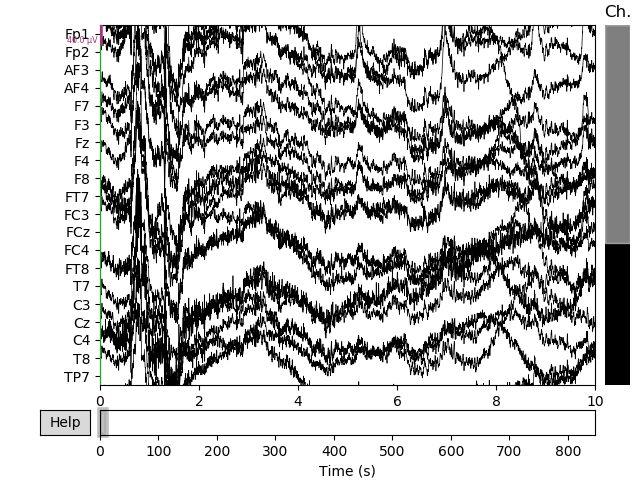

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 sec)

Plot EEG data after bandpass [1,40] Hz!


<IPython.core.display.Javascript object>


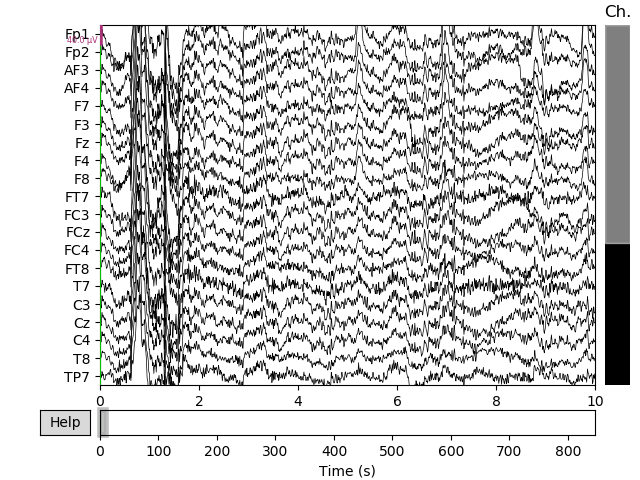

834 events found
Event IDs: [1 2 3]
Plot EEG data with events!


<IPython.core.display.Javascript object>


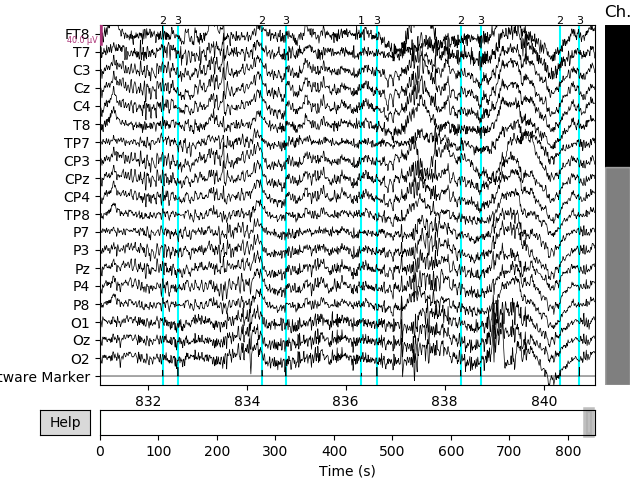

Start to extract epochs with artifact removal.
359 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Plot epochs!
Loading data for 359 events and 351 original time points ...
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['CP4']
    Rejecting  epoch based on EEG : ['AF3', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF3', 'AF4', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCz', 'FC4', 'FT8', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch 

<IPython.core.display.Javascript object>


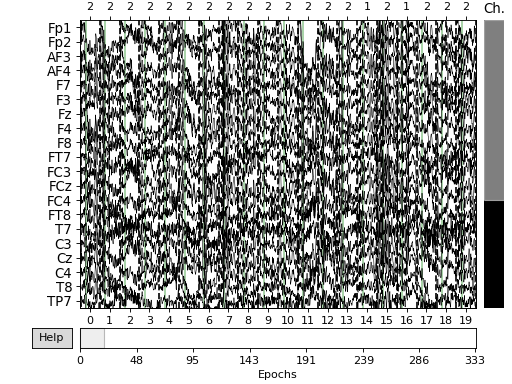

Loading data for 20 events and 351 original time points ...


In [10]:
raw, events, epochs=mneLoadIn(new_data)

The events list contains three columns.  
The first column corresponds to sample number.  
To convert this to seconds, you should divide the sample number by the used sampling frequency.  
The second column is reserved for the old value of the trigger channel at the time of transition, but is currently not in use.  The third column is the trigger id (amplitude of the pulse).

In [24]:
events

array([[  3104,      0,      2],
       [  3287,      0,      3],
       [  3606,      0,      2],
       ...,
       [421374,      0,      3],
       [422172,      0,      2],
       [422359,      0,      3]])

In [26]:
epochs.info

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fp2, AF3, AF4, F7, F3, Fz, F4, F8, FT7, FC3, FCz, FC4, FT8, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 1.0 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 500.0 Hz
>

### Unsolved issue: Montage

Deal with montage: https://mne.tools/dev/auto_tutorials/intro/plot_40_sensor_locations.html#sphx-glr-auto-tutorials-intro-plot-40-sensor-locations-py

In [11]:
from mpl_toolkits.mplot3d import Axes3D  # noqa

In [12]:
import os
montage_dir = os.path.join(os.path.dirname(mne.__file__),
                           'channels', 'data', 'montages')
print('\nBUILT-IN MONTAGE FILES')
print('======================')
print(sorted(os.listdir(montage_dir)))


BUILT-IN MONTAGE FILES
['EGI_256.csd', 'GSN-HydroCel-128.sfp', 'GSN-HydroCel-129.sfp', 'GSN-HydroCel-256.sfp', 'GSN-HydroCel-257.sfp', 'GSN-HydroCel-32.sfp', 'GSN-HydroCel-64_1.0.sfp', 'GSN-HydroCel-65_1.0.sfp', 'biosemi128.txt', 'biosemi16.txt', 'biosemi160.txt', 'biosemi256.txt', 'biosemi32.txt', 'biosemi64.txt', 'easycap-M1.txt', 'easycap-M10.txt', 'mgh60.elc', 'mgh70.elc', 'standard_1005.elc', 'standard_1020.elc', 'standard_alphabetic.elc', 'standard_postfixed.elc', 'standard_prefixed.elc', 'standard_primed.elc']


In [28]:
montage = mne.channels.make_standard_montage('biosemi64')
print(montage)

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 64 channels>


Creating RawArray with float64 data, n_channels=64, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


<IPython.core.display.Javascript object>


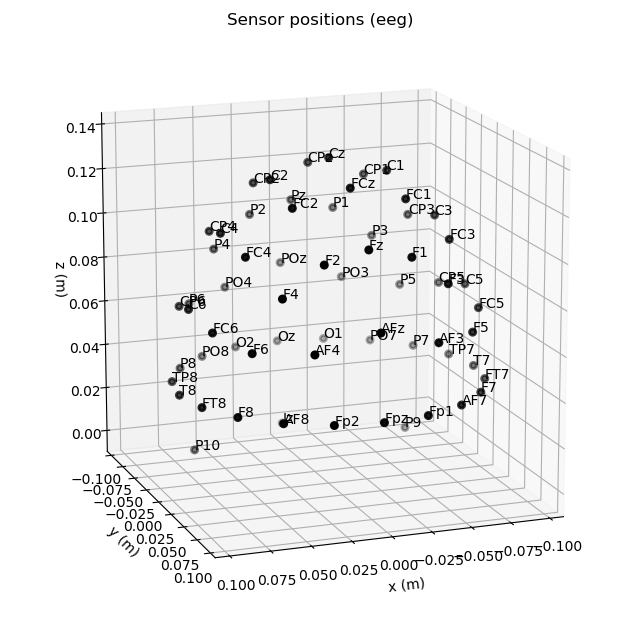

Creating RawArray with float64 data, n_channels=64, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


<IPython.core.display.Javascript object>


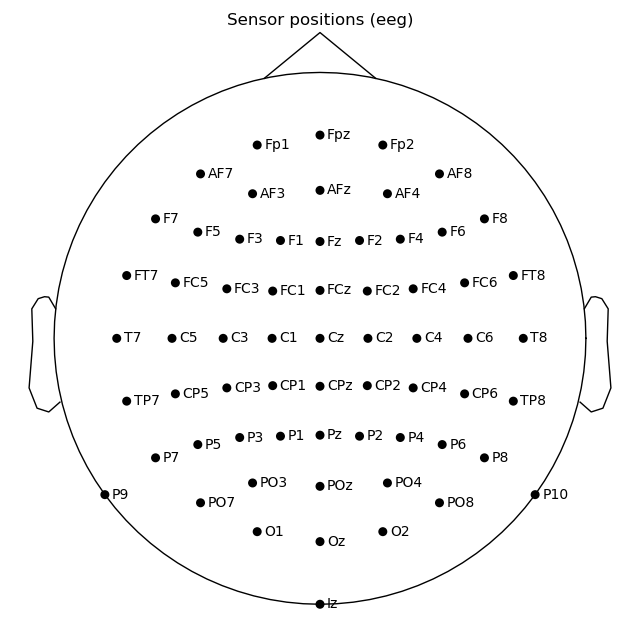

<IPython.core.display.Javascript object>


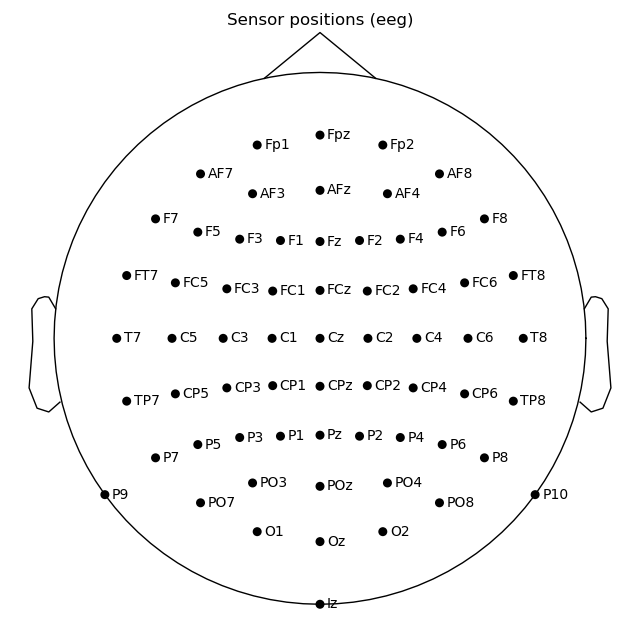

In [29]:
fig = montage.plot(kind='3d')
fig.gca().view_init(azim=70, elev=15)
montage.plot(kind='topomap', show_names=True)

In [15]:
ica = ICA(n_components=32, random_state=97)
ica.fit(epochs)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Loading data for 334 events and 351 original time points ...
Selecting by number: 32 components
Loading data for 334 events and 351 original time points ...
Fitting ICA took 8.9s.


<ICA  |  epochs decomposition, fit (fastica): 117234 samples, 32 components, channels used: "eeg">

Loading data for 334 events and 351 original time points ...


<IPython.core.display.Javascript object>


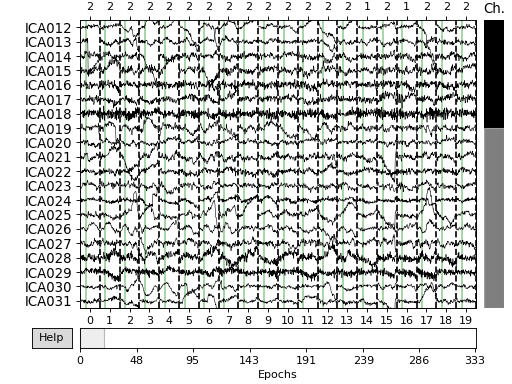

<IPython.core.display.Javascript object>


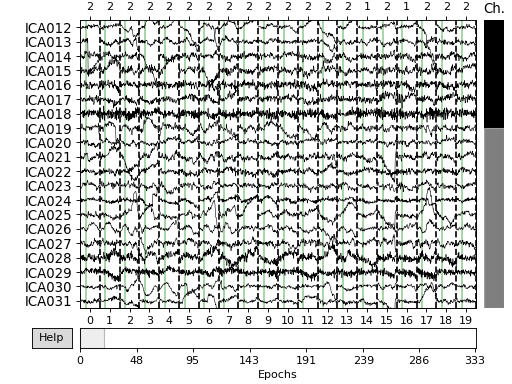

In [16]:
epochs.load_data()
ica.plot_sources(epochs)

<IPython.core.display.Javascript object>


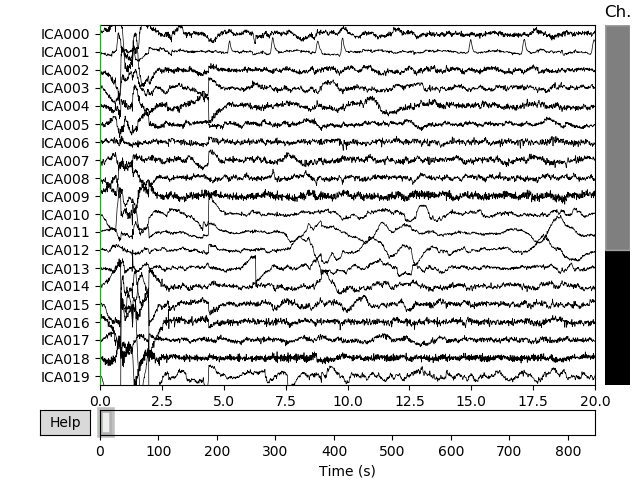

<IPython.core.display.Javascript object>


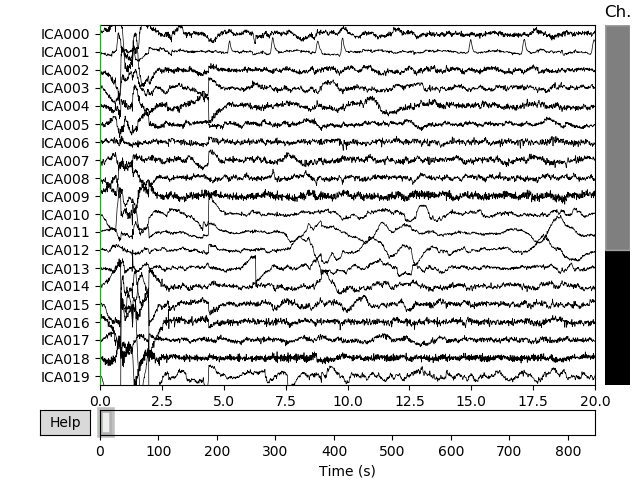

In [23]:
raw.load_data()
ica.plot_sources(raw)

In [17]:
ica.plot_components()

RuntimeError: No digitization points found.

### Plot psd

https://mne.tools/dev/auto_examples/time_frequency/plot_compute_raw_data_spectrum.html#sphx-glr-auto-examples-time-frequency-plot-compute-raw-data-spectrum-py

<IPython.core.display.Javascript object>


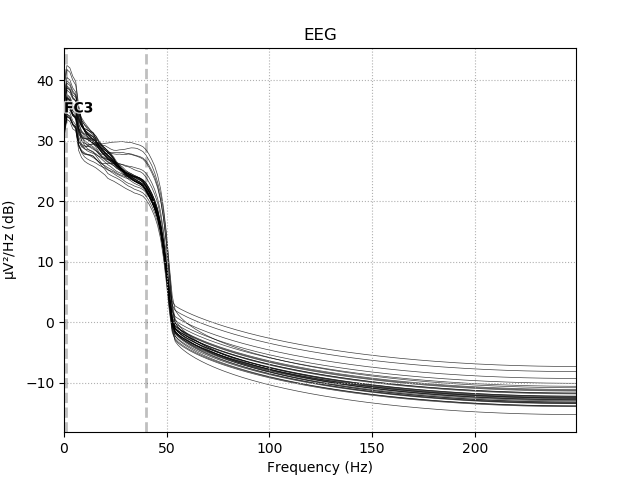

    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-18-697022bd73f1>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd()


<IPython.core.display.Javascript object>


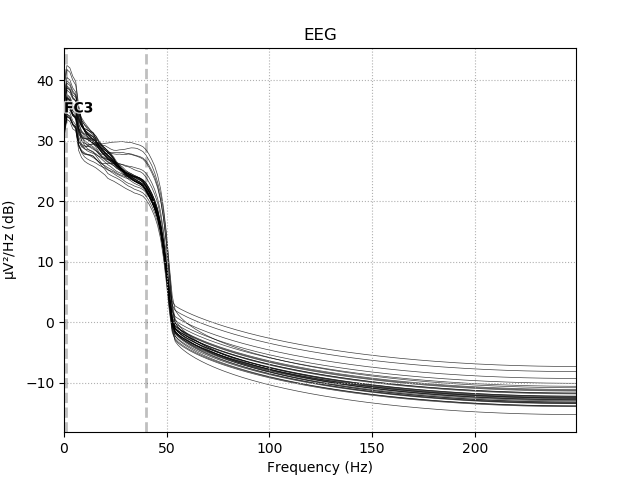

In [18]:
epochs.plot_psd()

<IPython.core.display.Javascript object>


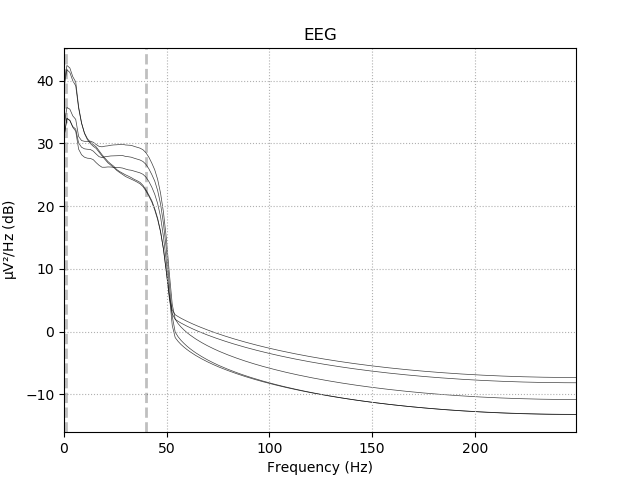

    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-27-8362a832abf6>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd(picks=['Fp1','Fp2','Oz','O1','O2'])


<IPython.core.display.Javascript object>


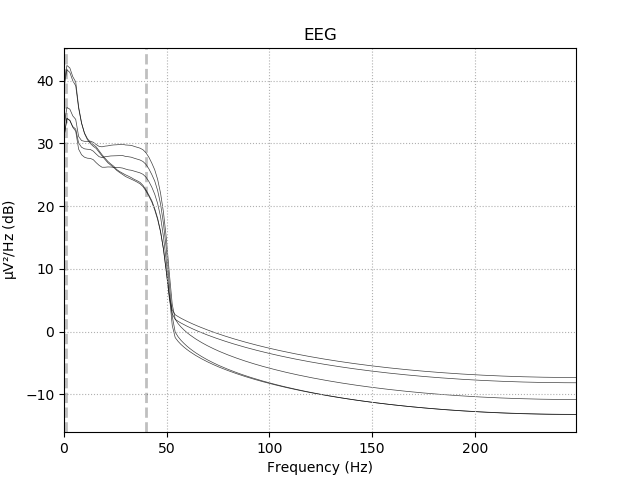

In [27]:
epochs.plot_psd(picks=['Fp1','Fp2','Oz','O1','O2'])

<IPython.core.display.Javascript object>


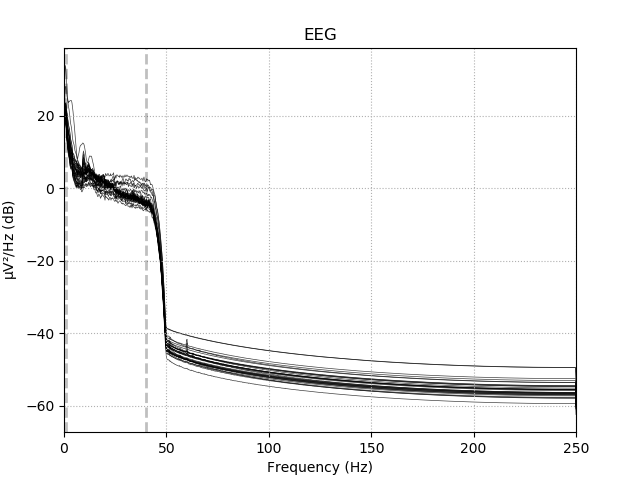

Effective window size : 4.096 (s)


<ipython-input-19-a5fcf744740b>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd()


<IPython.core.display.Javascript object>


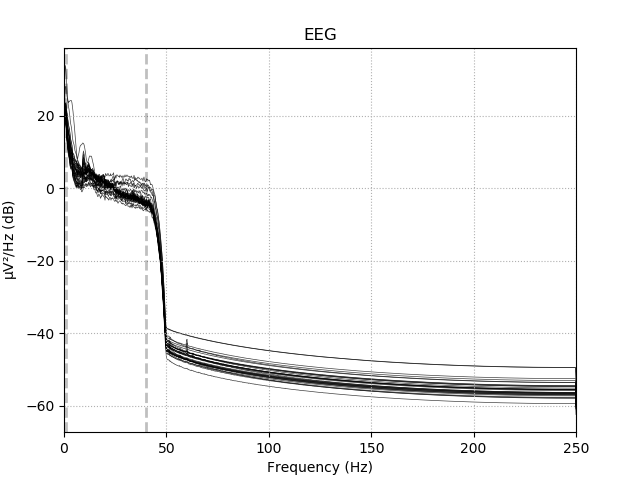

In [19]:
raw.plot_psd()

<IPython.core.display.Javascript object>


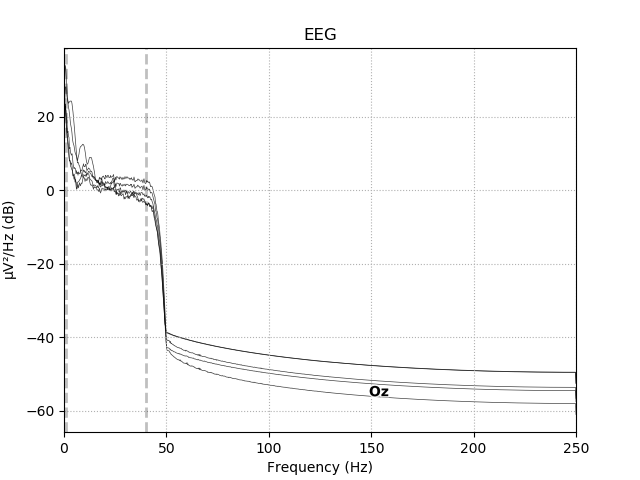

Effective window size : 4.096 (s)


<ipython-input-20-cd8664edd978>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(picks=['Fp1','Fp2','Oz','O1','O2'])# 'Fp1','Fp2','Oz','O1','O2'


<IPython.core.display.Javascript object>


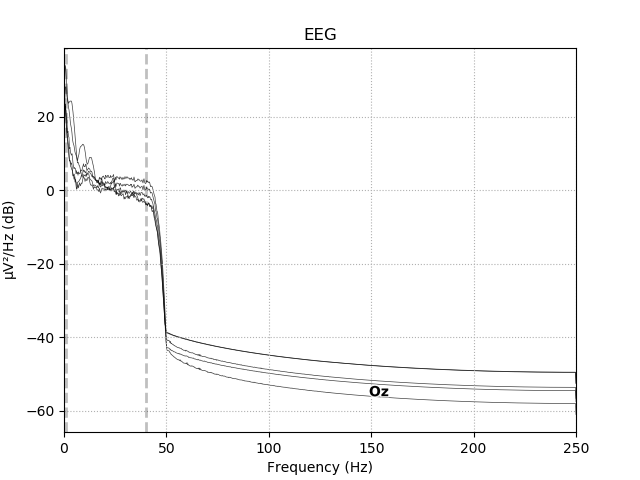

In [20]:
raw.plot_psd(picks=['Fp1','Fp2','Oz','O1','O2'])# 'Fp1','Fp2','Oz','O1','O2'